In [3]:
import numpy as np 
import pandas as pd 
import re,string
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

A - Analyse exploratoire

In [15]:
perc = (gop.isna().sum()/len(gop)*100).round(1)
misscount = gop.isna().sum()
missingtbl = pd.concat([perc.to_frame(), misscount.to_frame()], axis = 1)
missingtbl.columns = ['perc', 'misscount']
missingtbl

,perc,misscount
id,0.0,0
candidate,0.7,96
candidate_confidence,0.0,0
relevant_yn,0.0,0
relevant_yn_confidence,0.0,0
sentiment,0.0,0
sentiment_confidence,0.0,0
subject_matter,2.4,326
subject_matter_confidence,0.0,0
candidate_gold,99.8,13843


yes    13871
Name: relevant_yn, dtype: int64


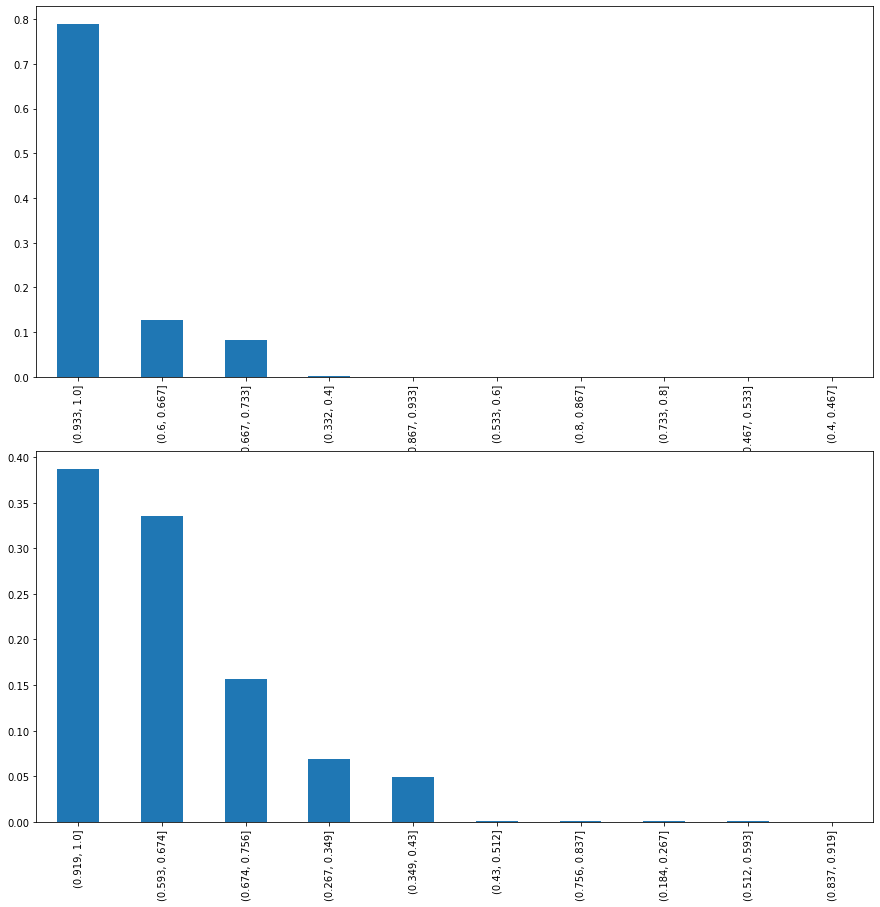

In [16]:
print(gop.relevant_yn.value_counts())
fig, axs = plt.subplots(2,figsize=(15,15))
gop.relevant_yn_confidence.value_counts(bins = 10, normalize = True).plot(kind = 'bar', ax = axs[0])
gop.sentiment_confidence.value_counts(bins = 10, normalize = True).plot(kind = 'bar', ax = axs[1])

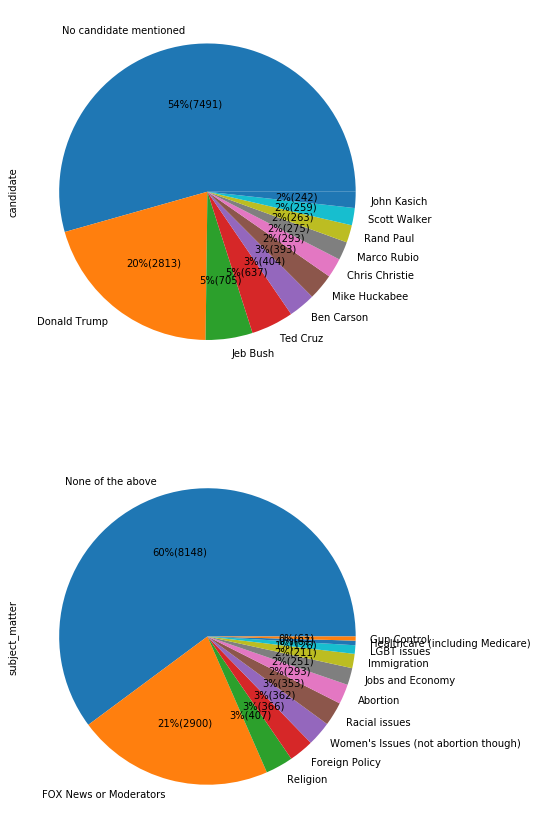

In [17]:
fig, axs = plt.subplots(2,figsize=(15,15))
gop.candidate.value_counts().plot(kind='pie', autopct=lambda 
                                  p: '{:1.0f}%({:.0f})'.format(p,(p/100)*gop.groupby('candidate').size().sum()), ax = axs[0])
gop.subject_matter.value_counts().plot(kind='pie', autopct=lambda 
                                  p: '{:1.0f}%({:.0f})'.format(p,(p/100)*gop.groupby('subject_matter').size().sum()), ax = axs[1])

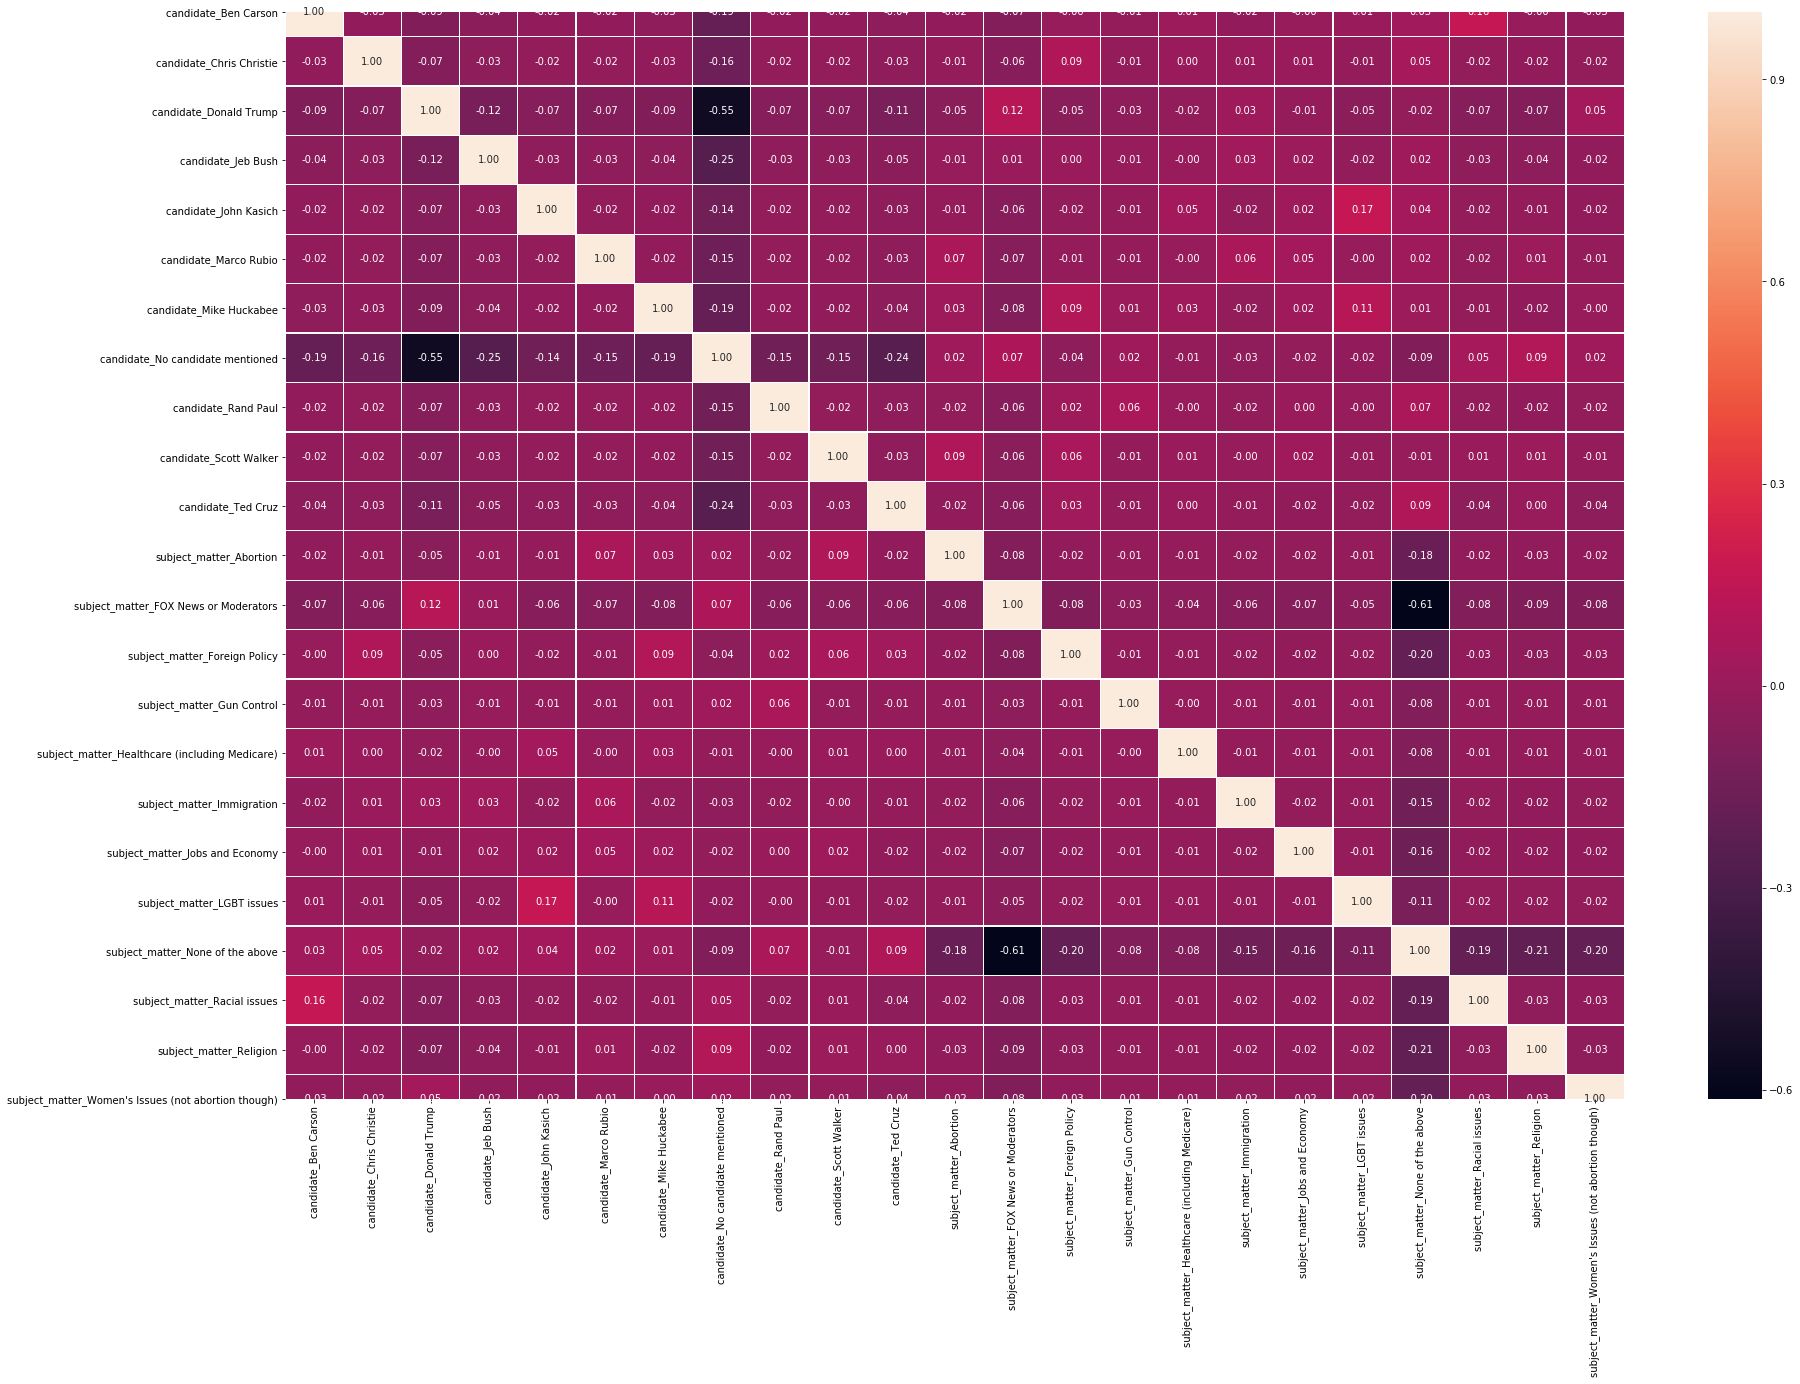

In [19]:
gop_corr = gop[['candidate','subject_matter']]
gop_corr = pd.get_dummies(gop_corr)
gop_corr
gop_corr = gop_corr[gop_corr.columns].corr()
plt.figure(figsize = (30,20))
import seaborn as sns
sns.heatmap(gop_corr, annot = True, linewidths=0.2, fmt=".2f")

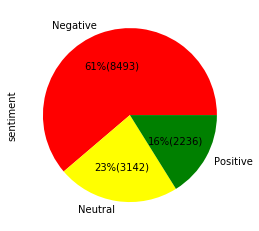

In [20]:
gop.sentiment.value_counts().plot(kind='pie', autopct=lambda 
                                  p: '{:1.0f}%({:.0f})'.format(p,(p/100)*gop.groupby('sentiment').size().sum()),
                                  colors=["red", "yellow", "green"])

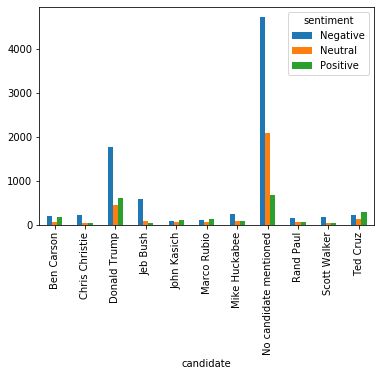

In [21]:
gops = gop.groupby(['candidate', 'sentiment']).sentiment.count().unstack()
gops.plot(kind='bar')

B - Traitement des tweets

In [2]:
gop = pd.read_csv('sentiment.csv')
tweet=gop['text']
sentiment=gop['sentiment']
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)
tweet=tweet.str.replace('(RT)','')
tokenizer=RegexpTokenizer(r"\w+")
newtweet=tweet.apply(lambda x: tokenizer.tokenize(x.lower()))
def remove_stopwords(text):
    words=[w for w in text if w not in stopwords.words('english')]
    return words
newtweet=newtweet.apply(lambda x: remove_stopwords(x))
lemmatizer=WordNetLemmatizer()
def word_lemmatizer(text):
    lem=" ".join([lemmatizer.lemmatize(i) for i in text])
    return lem
newtweet=newtweet.apply(lambda x: word_lemmatizer(x))
newtweet

0        nancyleegrahn everyone feel climate change que...
1        scottwalker catch full gopdebate last night sc...
2        tjmshow mention tamir rice gopdebate held clev...
3        robgeorge carly fiorina trending hour debate m...
4        danscavino gopdebate w realdonaldtrump deliver...
                               ...                        
13866    cappy_yarbrough love see men never faced pregn...
13867    georgehenryw thought huckabee exceeded expecta...
13868    lrihendry tedcruz president always tell truth ...
13869    jrehling gopdebate donald trump say time polit...
13870    lrihendry tedcruz headed presidential debate g...
Name: text, Length: 13871, dtype: object

Neutral words


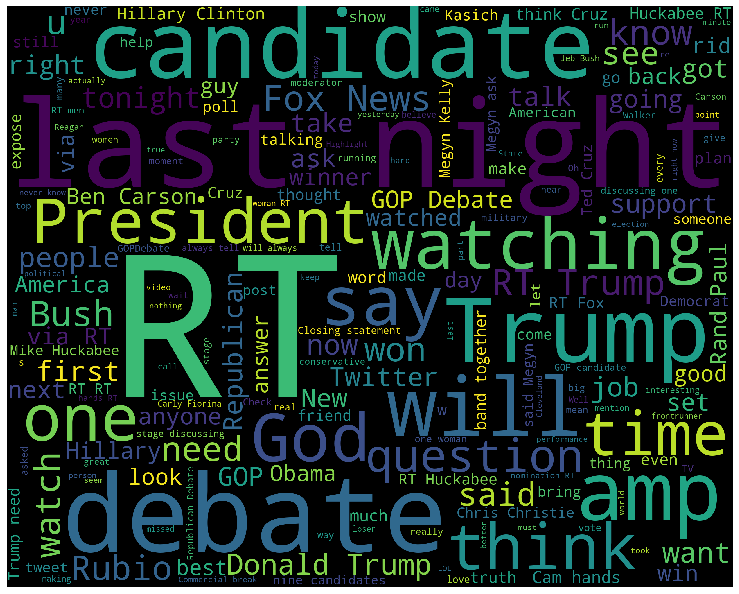

In [9]:
pos=gop[gop['sentiment']=='Positive']
pos=pos['text']
neg=gop[gop['sentiment']=='Negative']
neg=neg['text']
neuu=gop[gop['sentiment']=='Neutral']
neuu=neuu['text']

from wordcloud import WordCloud,STOPWORDS
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and not word.startswith('#')])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Neutral words")
wordcloud_draw(neuu)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer (max_features=2500) 
newtweet = vectorizer.fit_transform(newtweet).toarray()

In [4]:
gop['newsentiment']=gop['sentiment'].replace({'Negative':-1 ,'Neutral':0,'Positive':1})
newsentiment=np.array(gop['newsentiment'])

C - Train Test Split

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(newtweet, newsentiment, test_size=0.2, random_state=0)

SVC

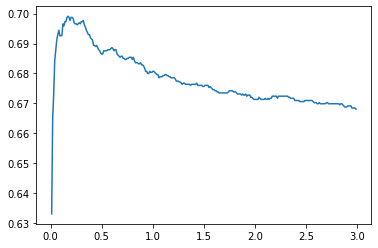

In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = []
wd=[]
k = range(1, 300, 1)
for i in k:
    j = i/100
    modelSVC = LinearSVC(penalty="l2",C=j, dual=False,tol=1e-4)
    modelSVC.fit(Xtrain,ytrain)
    ypredSVC = modelSVC.predict(Xtest)
    accuracy.append(accuracy_score(ytest, ypredSVC))
    wd.append(i/100)
plt.plot(wd,accuracy)

In [12]:
from sklearn.svm import LinearSVC
modelSVC = LinearSVC(penalty="l2",C=0.4, dual=False,tol=1e-4)
modelSVC.fit(Xtrain,ytrain)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
ypredSVC = modelSVC.predict(Xtest)
labels = np.unique(ytest)
print(pd.DataFrame(confusion_matrix(ytest,ypredSVC), columns = labels, index = labels ))
print('\n')
print(classification_report(ytest, ypredSVC))
print('accuracy score = {:.2f}'.format(accuracy_score(ytest, ypredSVC)))


      -1    0    1
-1  1455  138   77
 0   354  241   47
 1   180   60  223


              precision    recall  f1-score   support

          -1       0.73      0.87      0.80      1670
           0       0.55      0.38      0.45       642
           1       0.64      0.48      0.55       463

    accuracy                           0.69      2775
   macro avg       0.64      0.58      0.60      2775
weighted avg       0.67      0.69      0.67      2775

accuracy score = 0.69


KNN

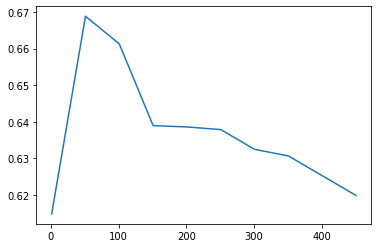

In [26]:
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
k = range(1,500,50)
for i in k :
    modelKNN = KNeighborsClassifier(i, weights = 'uniform')
    modelKNN.fit(Xtrain,ytrain)
    ypredKNN = modelKNN.predict(Xtest)
    accuracy.append(accuracy_score(ytest, ypredKNN))

plt.plot(k,accuracy)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
modelKNN = KNeighborsClassifier(150, weights = 'uniform')
modelKNN.fit(Xtrain,ytrain)
ypredKNN = modelKNN.predict(Xtest)

print(pd.DataFrame(confusion_matrix(ytest,ypredKNN), columns = labels, index = labels ))
print()
print(classification_report(ytest, ypredKNN))
print()
print('accuracy score = {:.2f}'.format(accuracy_score(ytest, ypredKNN)))

      -1    0   1
-1  1544   91  35
 0   458  166  18
 1   352   47  64

              precision    recall  f1-score   support

          -1       0.66      0.92      0.77      1670
           0       0.55      0.26      0.35       642
           1       0.55      0.14      0.22       463

    accuracy                           0.64      2775
   macro avg       0.58      0.44      0.45      2775
weighted avg       0.61      0.64      0.58      2775


accuracy score = 0.64


Random forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

In [4]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 1500, num = 100)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
max_leaf_nodes = [int(x) for x in np.linspace(10, 600, num = 20)]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'max_leaf_nodes': max_leaf_nodes}

In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.2min


In [11]:
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=60, max_depth=1200, min_samples_split=10, max_features=300, max_leaf_nodes=450)
text_classifier.fit(Xtrain, ytrain)
predictionstest = text_classifier.predict(Xtest)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#predictionstrain = text_classifier.predict(Xtrain)
#print(confusion_matrix(ytrain,predictionstrain))
#print(classification_report(ytrain,predictionstrain))
#print(accuracy_score(ytrain, predictionstrain))

print(confusion_matrix(ytest,predictionstest))
print()
print(classification_report(ytest,predictionstest))
print()
print('accuracy score = {:.2f}'.format(accuracy_score(ytest, predictionstest)))

[[1533   91   46]
 [ 432  175   35]
 [ 241   42  180]]

              precision    recall  f1-score   support

          -1       0.69      0.92      0.79      1670
           0       0.57      0.27      0.37       642
           1       0.69      0.39      0.50       463

    accuracy                           0.68      2775
   macro avg       0.65      0.53      0.55      2775
weighted avg       0.66      0.68      0.64      2775


accuracy score = 0.68


Naive Bayes Multinomial

In [14]:
from sklearn.naive_bayes import MultinomialNB
modelC = MultinomialNB()
modelC.fit(Xtrain, ytrain)
ypredtest = modelC.predict(Xtest)
from sklearn import metrics
print(confusion_matrix(ytest,ypredtest))
print(metrics.accuracy_score(ytest, ypredtest))
print(classification_report(ytest,ypredtest))
#ypredtrain = modelC.predict(Xtrain)
#print(confusion_matrix(ytrain, ypredtrain))
#print(metrics.accuracy_score(ytrain, ypredtrain))
#print(classification_report(ytrain, ypredtrain))

[[1552   84   34]
 [ 448  156   38]
 [ 255   41  167]]
0.6756756756756757
              precision    recall  f1-score   support

          -1       0.69      0.93      0.79      1670
           0       0.56      0.24      0.34       642
           1       0.70      0.36      0.48       463

    accuracy                           0.68      2775
   macro avg       0.65      0.51      0.53      2775
weighted avg       0.66      0.68      0.63      2775

[[6494  227  102]
 [1521  863  116]
 [ 962  121  690]]
0.7252162941600577
              precision    recall  f1-score   support

          -1       0.72      0.95      0.82      6823
           0       0.71      0.35      0.47      2500
           1       0.76      0.39      0.51      1773

    accuracy                           0.73     11096
   macro avg       0.73      0.56      0.60     11096
weighted avg       0.73      0.73      0.69     11096



D- Cross Validation / Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

Imbalanced Data

In [13]:
lr_cv(3, gop.text, gop.sentiment, original_pipeline, 'macro')

C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.72153674 0.54892966 0.72524752]
recall:    [0.90886613 0.34255725 0.39328859]
f1 score:  [0.80443958 0.42185664 0.5100087 ]
--------------------------------------------------


C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.71310573 0.54788069 0.75492958]
recall:    [0.91487107 0.33333333 0.35924933]
f1 score:  [0.80148538 0.41448931 0.48683015]
--------------------------------------------------


C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.71619738 0.54782609 0.70520231]
recall:    [0.9074532  0.36103152 0.32751678]
f1 score:  [0.80056092 0.43523316 0.44729606]
--------------------------------------------------
accuracy: 69.37% (+/- 0.29%)
precision: 66.45% (+/- 0.64%)
recall: 53.87% (+/- 0.69%)
f1 score: 56.91% (+/- 0.73%)


Random OverSampler

In [14]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)
lr_cv(3, gop.text, gop.sentiment, ROS_pipeline, 'macro')

C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.80030086 0.47004608 0.52386364]
recall:    [0.75167785 0.48664122 0.61879195]
f1 score:  [0.77522769 0.47819972 0.56738462]
--------------------------------------------------


C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.79062849 0.46902655 0.5552795 ]
recall:    [0.75097139 0.50620821 0.59919571]
f1 score:  [0.77028986 0.48690859 0.57640232]
--------------------------------------------------


C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.79432624 0.46872322 0.55598456]
recall:    [0.75167785 0.52244508 0.57986577]
f1 score:  [0.77241379 0.49412827 0.56767411]
--------------------------------------------------
accuracy: 67.11% (+/- 0.08%)
precision: 60.31% (+/- 0.36%)
recall: 61.86% (+/- 0.04%)
f1 score: 60.98% (+/- 0.21%)


SMOTE

In [15]:
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)
lr_cv(3, gop.text, gop.sentiment, SMOTE_pipeline, 'macro')

C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.80022659 0.46936937 0.52886836]
recall:    [0.74849876 0.4971374  0.6147651 ]
f1 score:  [0.77349881 0.48285449 0.56859094]
--------------------------------------------------


C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.79288625 0.4676007  0.56704981]
recall:    [0.75591664 0.51002865 0.59517426]
f1 score:  [0.77396022 0.48789402 0.58077175]
--------------------------------------------------


C:\Users\15142\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              negative    neutral     positive
precision: [0.78976848 0.45759866 0.55835544]
recall:    [0.74708584 0.52053486 0.56510067]
f1 score:  [0.76783445 0.487042   0.56170781]
--------------------------------------------------
accuracy: 67.02% (+/- 0.32%)
precision: 60.35% (+/- 0.41%)
recall: 61.71% (+/- 0.44%)
f1 score: 60.94% (+/- 0.36%)
